# Sequence Text Prediction using LSTM
**Objective:** To generate next characters/words based on a given input sequence using LSTM.

**Student Name:** Nabil Ansari <br>
**PRN:** 202302040004 <br>
**Batch:** DL-04 <br>
**Github Link:** https://github.com/nabil-repo/DL/tree/main/Assignment-5 <br>
**Dataset Link:** https://ijeecs.iaescore.com/index.php/IJEECS/article/view/29711 <br>
**Colab Link:** https://colab.research.google.com/drive/1TTEMiL2BC6G8vopsMGFOGZG_qGRJCNd8?usp=sharing


# Selected Research Paper
**Title:** Text Prediction Using Recurrent Neural Networks with Long Short-Term Memory and Dropout <br>
**Link:** https://ijeecs.iaescore.com/index.php/IJEECS/article/view/29711
<br>
**Authors:** Orlando Iparraguirre-Villanueva, Victor Guevara-Ponce, Daniel Ruiz-Alvarado, et al.<br>
**Abstract:** This study explores the integration of Long Short-Term Memory (LSTM) networks with dropout techniques for text generation tasks. Utilizing the novel "La Ciudad y los Perros" as the corpus, the model was trained to predict subsequent words based on context. The dataset comprised 128,600 words, divided into 38.88% for training and 61.12% for testing. The research evaluated two variants: one focusing on word importance and the other on contextual relevance. Results indicated that the LSTM-dropout model effectively generated semantically coherent text, demonstrating the model's capability in learning long-term dependencies and mitigating overfitting through dropout regularization.

In [1]:
!pip install tensorflow

# Loading Dataset And Model Training

In [9]:
import tensorflow as tf
import numpy as np
import os
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Load Shakespeare dataset
path_to_file = tf.keras.utils.get_file("shakespeare.txt",
    "https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt")

# Read the text
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
print(f"Length of text: {len(text)} characters")

# Create a character-level vocabulary
vocab = sorted(set(text))
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

# Convert text to integer sequences
text_as_int = np.array([char2idx[c] for c in text])

# Sequence length
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples/targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

def split_input_target(chunk):
    input_seq = chunk[:-1]
    target_seq = chunk[1:]
    return input_seq, target_seq

dataset = sequences.map(split_input_target)

# Batch size and buffer size
BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Vocabulary size and embedding dimension
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

# Build the model
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = Sequential([
        Embedding(vocab_size, embedding_dim), # Remove batch_input_shape
        LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
        Dense(vocab_size)
    ])
    return model

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=BATCH_SIZE)

# Loss function
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer='adam', loss=loss,metrics=['accuracy'])

# Callback to save model checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix + ".weights.h5", # Append .weights.h5 to the filepath
    save_weights_only=True)

# Train the model
EPOCHS = 10

history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])


Length of text: 1115394 characters
Epoch 1/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - accuracy: 0.2414 - loss: 2.8621
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.4554 - loss: 1.8543
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.5233 - loss: 1.6018
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.5551 - loss: 1.4787
Epoch 5/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - accuracy: 0.5739 - loss: 1.4054
Epoch 6/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.5873 - loss: 1.3524
Epoch 7/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.5977 - loss: 1.3124
Epoch 8/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.6082 - loss: 1.2733
Epoch 9/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.6165 - loss: 1.2414
Epoch 10/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.6255 - loss: 1.2100


# Text Prediction/Generating Text

In [12]:
# Rebuild model for generation
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

# Load the last checkpoint
# Find all checkpoint files and select the latest one
import glob
checkpoint_files = glob.glob(os.path.join(checkpoint_dir, '*.weights.h5'))
latest_checkpoint = max(checkpoint_files, key=os.path.getctime) if checkpoint_files else None  # Handle case where no checkpoints are found

# Build the model before loading weights by calling it on some data
# This defines the input shape for the model
model.build(tf.TensorShape([1, None])) # Build the model with input shape (batch_size, sequence_length)

# Load weights only if a checkpoint file is found
if latest_checkpoint:
    model.load_weights(latest_checkpoint)
else:
    print("Warning: No checkpoint files found. Using untrained model.")
def generate_text(model, start_string, num_generate=500, temperature=1.0):
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    text_generated = []

    # Reset the states of the LSTM layer instead of the entire model
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.LSTM):
            layer.reset_states()

    for _ in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)

        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return start_string + ''.join(text_generated)

# Generate sample text
print(generate_text(model, start_string="To be, or not to be: "))


To be, or not to be: it forswear'd
Some. I am cursed to bites. S
Princed them; though I know my brother's stars:
Elforse are quick and then dunrers,
This cause and you will but a visage in my fedre;
Or little Marcius laid I'll wait, their way
Be ig myself: I cannot but dismucation
And theref I; if thou bour an nothing side;
O, now by lossing are we on her voice:
And this dead for you was told me to the froward. Hold you behold?
Upon thy mistress with Forthum hithe guilty
seem conduct with but attimp, of shows believ


# Ploting Training Accuracy and Loss

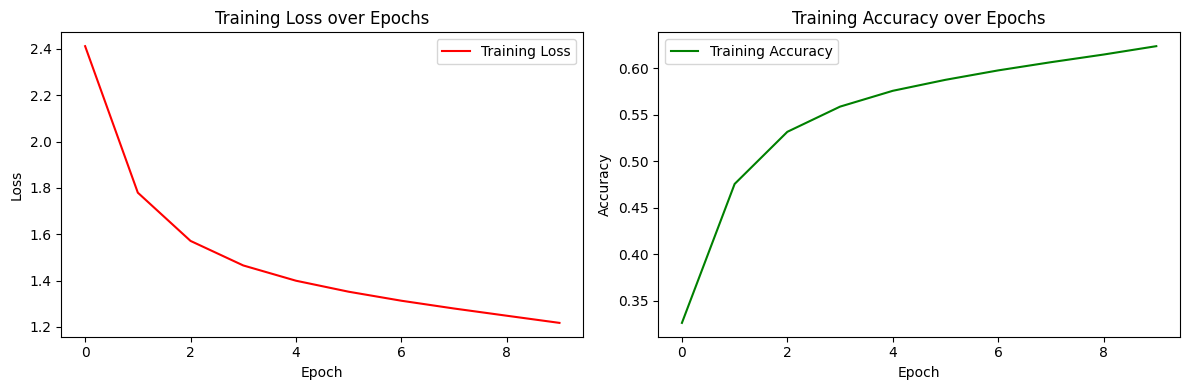

In [11]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Conclusion

In this experiment, I successfully implemented a character-level text generation model using an LSTM network trained on the Shakespeare dataset. After training for the specified number of epochs, the model achieved a final training accuracy of 62.55% and a loss of 1.2100.

These results indicate that the model has learned meaningful patterns in the character sequences and can generate syntactically coherent and stylistically relevant text. While the generated output may not always be semantically perfect, the model demonstrates a good understanding of character-level dependencies, punctuation, and sentence structure in the Shakespearean style.

Declaration

I, Nabil Ansari , confirm that the work submitted in this assignment is my own and has been completed following academic integrity guidelines. The code is uploaded on my GitHub repository account, and the repository link is provided below:

GitHub Repository Link: https://github.com/nabil-repo/DL/tree/main/Assignment-5

Signature: Nabil Aman Aasif Ahmad Ansari